In [1]:
# Cell 1: Setup and Installation
import numpy as np
import pandas as pd
import os

print("Exploring data directory structure...")
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Exploring data directory structure...
./data/all_image_urls.csv
./data/annotations.json
./data/annotations_unofficial.json
./data/batch_13/000090.jpg
./data/batch_13/000092.jpg
./data/batch_13/000091.jpg
./data/batch_13/000001.jpg
./data/batch_13/000093.jpg
./data/batch_13/000017.jpg
./data/batch_13/000096.jpg
./data/batch_13/000012.jpg
./data/batch_13/000073.jpg
./data/batch_13/000062.jpg
./data/batch_13/000013.jpg
./data/batch_13/000019.jpg
./data/batch_13/000053.jpg
./data/batch_13/000044.jpg
./data/batch_13/000010.jpg
./data/batch_13/000072.jpg
./data/batch_13/000063.jpg
./data/batch_13/000007.jpg
./data/batch_13/000051.jpg
./data/batch_13/000036.jpg
./data/batch_13/000095.jpg
./data/batch_13/000080.jpg
./data/batch_13/000042.jpg
./data/batch_13/000027.jpg
./data/batch_13/000067.jpg
./data/batch_13/000059.jpg
./data/batch_13/000064.jpg
./data/batch_13/000020.jpg
./data/batch_13/000074.jpg
./data/batch_13/000060.jpg
./data/batch_13/000014.jpg
./data/batch_13/000032.jpg
./data/batch_

In [2]:
# Cell 2: Install Required Libraries
!pip install -U ultralytics

# Import required libraries
import json
import os
from sklearn.model_selection import train_test_split
import shutil
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')

# Verify installation
import ultralytics
ultralytics.checks()

print("All libraries imported successfully!")

Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
Setup complete ✅ (28 CPUs, 31.1 GB RAM, 425.3/914.8 GB disk)
All libraries imported successfully!


In [3]:
# Cell 3: Examine TACO Dataset
# Load and examine the TACO annotations
json_path = './data/annotations.json'

with open(json_path, 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']
categories = data['categories']

print(f"📊 TACO Dataset Overview:")
print(f"   Total images: {len(images)}")
print(f"   Total annotations: {len(annotations)}")
print(f"   Total categories: {len(categories)}")
print(f"   Average annotations per image: {len(annotations)/len(images):.2f}")

# Show first few categories
print(f"\n🏷️  First 10 categories:")
for i, cat in enumerate(categories[:10]):
    print(f"   {cat['id']}: {cat['name']}")

# Show dataset distribution
print(f"\n📁 Image file structure (first 5):")
for img in images[:5]:
    print(f"   {img['file_name']} ({img['width']}x{img['height']})")

📊 TACO Dataset Overview:
   Total images: 1500
   Total annotations: 4784
   Total categories: 60
   Average annotations per image: 3.19

🏷️  First 10 categories:
   0: Aluminium foil
   1: Battery
   2: Aluminium blister pack
   3: Carded blister pack
   4: Other plastic bottle
   5: Clear plastic bottle
   6: Glass bottle
   7: Plastic bottle cap
   8: Metal bottle cap
   9: Broken glass

📁 Image file structure (first 5):
   batch_1/000006.jpg (1537x2049)
   batch_1/000008.jpg (1537x2049)
   batch_1/000010.jpg (1537x2049)
   batch_1/000019.jpg (2049x1537)
   batch_1/000026.jpg (1537x2049)


In [4]:
# Cell 3a: Count Available Images in Batch Folders
import os
from collections import defaultdict

def count_images_in_batches(data_dir='./data'):
    """Count actual images available in batch folders"""

    print("📁 Counting images in batch folders...")
    print("="*50)

    batch_counts = defaultdict(int)
    total_images = 0
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']

    # Look for batch folders
    batch_folders = []
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path) and 'batch' in item.lower():
            batch_folders.append(item)

    batch_folders.sort()  # Sort for consistent output

    if not batch_folders:
        print("⚠️  No batch folders found in ./data/")
        return 0, {}

    # Count images in each batch folder
    for batch_folder in batch_folders:
        batch_path = os.path.join(data_dir, batch_folder)

        # Count image files
        image_count = 0
        for file in os.listdir(batch_path):
            if any(file.endswith(ext) for ext in image_extensions):
                image_count += 1

        batch_counts[batch_folder] = image_count
        total_images += image_count

        print(f"   📂 {batch_folder}: {image_count:,} images")

    print("-" * 50)
    print(f"📊 TOTAL IMAGES AVAILABLE: {total_images:,}")

    return total_images, dict(batch_counts)

def compare_with_annotations(total_available, annotations):
    """Compare available images with annotation records"""

    print("\n🔍 ANNOTATION vs AVAILABLE COMPARISON:")
    print("="*50)

    annotated_count = len([img for img in annotations if 'file_name' in img])

    print(f"📄 Images in annotations.json: {annotated_count:,}")
    print(f"📁 Images in batch folders:    {total_available:,}")

    if total_available == annotated_count:
        print("✅ Perfect match! All annotated images are available")
        availability = 100.0
    elif total_available > annotated_count:
        extra = total_available - annotated_count
        print(f"📈 You have {extra:,} extra images (not in annotations)")
        availability = (annotated_count / total_available) * 100
    else:
        missing = annotated_count - total_available
        print(f"⚠️  {missing:,} annotated images are missing from folders")
        availability = (total_available / annotated_count) * 100

    print(f"📊 Availability rate: {availability:.1f}%")

    return availability

# Run the image counting
total_available, batch_counts = count_images_in_batches()

if total_available > 0:
    # Compare with annotations
    availability = compare_with_annotations(total_available, images)

    # Summary
    print(f"\n💡 SUMMARY:")
    if availability >= 95:
        print("   🎯 Excellent! Ready for training")
    elif availability >= 80:
        print("   ✅ Good availability, should work well")
    elif availability >= 60:
        print("   ⚠️  Some images missing, but usable")
    else:
        print("   ❌ Many images missing, check data setup")

    print(f"   📊 Dataset size: {total_available:,} images across {len(batch_counts)} batches")

    # Show largest batches
    if len(batch_counts) > 1:
        largest_batches = sorted(batch_counts.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"   📈 Largest batches: {', '.join([f'{b}({c})' for b, c in largest_batches])}")

📁 Counting images in batch folders...
   📂 batch_1: 101 images
   📂 batch_10: 100 images
   📂 batch_11: 100 images
   📂 batch_12: 100 images
   📂 batch_13: 100 images
   📂 batch_14: 100 images
   📂 batch_15: 85 images
   📂 batch_2: 92 images
   📂 batch_3: 97 images
   📂 batch_4: 89 images
   📂 batch_5: 112 images
   📂 batch_6: 97 images
   📂 batch_7: 127 images
   📂 batch_8: 100 images
   📂 batch_9: 100 images
--------------------------------------------------
📊 TOTAL IMAGES AVAILABLE: 1,500

🔍 ANNOTATION vs AVAILABLE COMPARISON:
📄 Images in annotations.json: 1,500
📁 Images in batch folders:    1,500
✅ Perfect match! All annotated images are available
📊 Availability rate: 100.0%

💡 SUMMARY:
   🎯 Excellent! Ready for training
   📊 Dataset size: 1,500 images across 15 batches
   📈 Largest batches: batch_7(127), batch_5(112), batch_1(101)


In [5]:
# Cell 4: Define Class Mapping and Conversion Functions (FIXED VERSION)
def create_class_mapping():
    """Create mapping from original TACO classes to consolidated categories"""

    class_mapping = {
        # Bottle category
        'Clear plastic bottle': 'Bottle',
        'Glass bottle': 'Bottle',
        'Other plastic bottle': 'Bottle',

        # Bottle cap category
        'Plastic bottle cap': 'Bottle cap',
        'Metal bottle cap': 'Bottle cap',

        # Can category
        'Drink can': 'Can',
        'Food Can': 'Can',

        # Cigarette category
        'Cigarette': 'Cigarette',

        # Cup category
        'Paper cup': 'Cup',
        'Disposable plastic cup': 'Cup',
        'Foam cup': 'Cup',
        'Glass cup': 'Cup',
        'Other plastic cup': 'Cup',

        # Lid category
        'Plastic lid': 'Lid',
        'Metal lid': 'Lid',

        # Plastic bag + wrapper category
        'Garbage bag': 'Plastic bag + wrapper',
        'Single-use carrier bag': 'Plastic bag + wrapper',
        'Polypropylene bag': 'Plastic bag + wrapper',
        'Produce bag': 'Plastic bag + wrapper',
        'Cereal bag': 'Plastic bag + wrapper',
        'Bread bag': 'Plastic bag + wrapper',
        'Plastic film': 'Plastic bag + wrapper',
        'Crisp packet': 'Plastic bag + wrapper',
        'Other plastic wrapper': 'Plastic bag + wrapper',
        'Retort pouch': 'Plastic bag + wrapper',
        'Six pack rings': 'Plastic bag + wrapper',

        # Pop tab category
        'Pop tab': 'Pop tab',

        # Straw category
        'Plastic straw': 'Straw',
        'Paper straw': 'Straw',

        # Other category (everything else)
        'Aluminium foil': 'Other',
        'Battery': 'Other',
        'Aluminium blister pack': 'Other',
        'Carded blister pack': 'Other',
        'Broken glass': 'Other',
        'Corrugated carton': 'Other',
        'Drink carton': 'Other',
        'Egg carton': 'Other',
        'Meal carton': 'Other',
        'Other carton': 'Other',
        'Food waste': 'Other',
        'Magazine paper': 'Other',
        'Tissues': 'Other',
        'Wrapping paper': 'Other',
        'Normal paper': 'Other',
        'Paper bag': 'Other',
        'Plastified paper bag': 'Other',
        'Pizza box': 'Other',
        'Spread tub': 'Other',
        'Tupperware': 'Other',
        'Disposable food container': 'Other',
        'Foam food container': 'Other',
        'Other plastic container': 'Other',
        'Plastic gloves': 'Other',
        'Plastic glooves': 'Other',  # Handle the typo in your data
        'Plastic utensils': 'Other',
        'Rope & strings': 'Other',
        'Scrap metal': 'Other',
        'Shoe': 'Other',
        'Squeezable tube': 'Other',
        'Styrofoam piece': 'Other',
        'Toilet tube': 'Other',
        'Unlabeled litter': 'Other',
        'Glass jar': 'Other',
        'Other plastic': 'Other',
        'Aerosol': 'Other'  # Handle the unmapped class found in your data
    }

    return class_mapping

def analyze_class_distribution(annotations, categories, class_mapping):
    """Analyze class distribution before and after mapping"""

    print("📊 Class Distribution Analysis")
    print("="*50)

    # Count original classes
    original_counts = Counter()
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}

    for ann in annotations:
        category_name = category_id_to_name[ann['category_id']]
        original_counts[category_name] += 1

    # Count mapped classes
    mapped_counts = Counter()
    for ann in annotations:
        category_name = category_id_to_name[ann['category_id']]
        mapped_category = class_mapping.get(category_name, 'Other')
        mapped_counts[mapped_category] += 1

    print(f"📈 Original classes: {len(original_counts)} classes")
    print(f"📈 Mapped classes: {len(mapped_counts)} classes")
    print(f"🔄 Reduction: {len(original_counts) - len(mapped_counts)} classes removed")

    print(f"\n🏷️  Mapped Class Distribution:")
    for category, count in sorted(mapped_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / sum(mapped_counts.values())) * 100
        print(f"   {category:25}: {count:5} annotations ({percentage:5.1f}%)")

    return original_counts, mapped_counts

def convert_taco_to_yolo_with_mapping_fixed(json_path, image_root_dir, output_dir):
    """
    Convert TACO dataset from COCO format to YOLO format with class mapping
    FIXED: Prevents filename collisions by including batch name in filename
    """

    print("🔄 Loading TACO annotations...")
    with open(json_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = data['categories']

    print(f"Found {len(images)} images, {len(annotations)} annotations, {len(categories)} categories")

    # Create class mapping
    class_mapping = create_class_mapping()

    # Analyze class distribution
    original_counts, mapped_counts = analyze_class_distribution(annotations, categories, class_mapping)

    # Create output directories
    print("\n📁 Creating output directories...")
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)

    # Split dataset into train/val
    image_ids = [img['id'] for img in images]
    train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

    print(f"📊 Train set: {len(train_ids)} images")
    print(f"📊 Validation set: {len(val_ids)} images")

    # Create lookup dictionaries
    image_id_to_filename = {img['id']: img['file_name'] for img in images}
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}

    # Create mapped categories and YOLO class mapping
    mapped_categories = sorted(list(set(class_mapping.values())))
    mapped_category_to_yolo_id = {cat: idx for idx, cat in enumerate(mapped_categories)}

    print(f"\n🏷️  Final mapped categories ({len(mapped_categories)}):")
    for i, cat in enumerate(mapped_categories):
        print(f"   {i}: {cat}")

    print("\n🔄 Converting images and annotations...")
    copied_count = 0
    missing_count = 0
    collision_count = 0
    conversion_stats = defaultdict(int)

    # Track renamed files for label creation
    old_to_new_filename = {}

    for i, img in enumerate(images):
        if i % 500 == 0:
            print(f"   Processed {i}/{len(images)} images...")

        img_id = img['id']
        filename = img['file_name']  # e.g., "batch_1/000000.jpg"
        img_width = img['width']
        img_height = img['height']

        # Determine train or val
        if img_id in train_ids:
            image_dir = os.path.join(output_dir, 'images/train')
            label_dir = os.path.join(output_dir, 'labels/train')
        else:
            image_dir = os.path.join(output_dir, 'images/val')
            label_dir = os.path.join(output_dir, 'labels/val')

        # Construct full image path
        full_image_path = os.path.join(image_root_dir, filename)

        # FIXED: Create unique filename to prevent collisions
        # Extract batch name and original filename
        if '/' in filename:
            batch_name, original_filename = filename.split('/', 1)
        else:
            batch_name = 'root'
            original_filename = filename

        # Create new unique filename: batch_name + "_" + original_filename
        # batch_1/000000.jpg → batch_1_000000.jpg
        new_filename = f"{batch_name}_{original_filename}"

        # Store mapping for label file creation
        old_to_new_filename[filename] = new_filename

        # Check for existing file with same new name (shouldn't happen, but safety check)
        destination_path = os.path.join(image_dir, new_filename)
        if os.path.exists(destination_path):
            collision_count += 1
            # Add image ID to make it unique
            name_part, ext = os.path.splitext(new_filename)
            new_filename = f"{name_part}_id{img_id}{ext}"
            destination_path = os.path.join(image_dir, new_filename)
            old_to_new_filename[filename] = new_filename

        if os.path.exists(full_image_path):
            # Copy image with new unique name
            shutil.copy(full_image_path, destination_path)
            copied_count += 1
        else:
            if missing_count < 10:
                print(f"⚠️  Warning: Image {full_image_path} not found.")
            missing_count += 1
            continue

        # Create label file with mapped classes
        label_filename = new_filename.replace('.jpg', '.txt').replace('.JPG', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_file = os.path.join(label_dir, label_filename)

        with open(label_file, 'w') as lf:
            for ann in annotations:
                if ann['image_id'] == img_id:
                    # Get original category name
                    original_category = category_id_to_name[ann['category_id']]

                    # Map to new category
                    mapped_category = class_mapping.get(original_category, 'Other')
                    yolo_class_id = mapped_category_to_yolo_id[mapped_category]

                    # Track conversion statistics
                    conversion_stats[f"{original_category} -> {mapped_category}"] += 1

                    bbox = ann['bbox']  # [x, y, width, height] in COCO format

                    # Convert to YOLO format (normalized center coordinates)
                    x_center = (bbox[0] + bbox[2] / 2) / img_width
                    y_center = (bbox[1] + bbox[3] / 2) / img_height
                    width = bbox[2] / img_width
                    height = bbox[3] / img_height

                    lf.write(f"{yolo_class_id} {x_center} {y_center} {width} {height}\n")

    print(f"\n✅ Successfully copied {copied_count} images")
    print(f"❌ Missing images: {missing_count}")
    if collision_count > 0:
        print(f"🔄 Resolved filename collisions: {collision_count}")

    return mapped_category_to_yolo_id, mapped_categories, class_mapping, conversion_stats

def create_data_yaml_with_mapping_fixed(output_dir, mapped_categories, mapped_category_to_yolo_id):
    """Create data.yaml file for YOLO training with mapped classes"""

    # Create class names list in YOLO order
    class_names = [""] * len(mapped_category_to_yolo_id)
    for category, yolo_id in mapped_category_to_yolo_id.items():
        class_names[yolo_id] = category

    yaml_content = f"""# TACO Dataset YOLO Configuration (Mapped Classes - Fixed Collisions)
train: {os.path.abspath(os.path.join(output_dir, 'images/train'))}
val: {os.path.abspath(os.path.join(output_dir, 'images/val'))}

nc: {len(class_names)}
names: {class_names}
"""

    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print(f"\n📄 Created {yaml_path}")
    print(f"📊 Number of mapped classes: {len(class_names)}")
    print("🏷️  Final class names:", class_names)

    return yaml_path

def save_mapping_info(output_dir, class_mapping, conversion_stats, mapped_counts):
    """Save class mapping information for reference"""

    mapping_info = {
        "class_mapping": class_mapping,
        "conversion_statistics": dict(conversion_stats),
        "final_class_distribution": dict(mapped_counts),
        "total_mapped_classes": len(set(class_mapping.values()))
    }

    mapping_path = os.path.join(output_dir, 'class_mapping_info.json')
    with open(mapping_path, 'w') as f:
        json.dump(mapping_info, f, indent=2)

    print(f"📋 Class mapping info saved to: {mapping_path}")

print("✅ FIXED class mapping and conversion functions defined!")
print("🔧 Filename collisions will be prevented by including batch names")

✅ FIXED class mapping and conversion functions defined!
🔧 Filename collisions will be prevented by including batch names


In [6]:
# Cell 5: Convert TACO to YOLO with Class Mapping (FIXED VERSION)
# Clean old output first
import shutil
if os.path.exists('./output'):
    shutil.rmtree('./output')
    print("🧹 Cleaned old output directory")

json_path = './data/annotations.json'
image_root_dir = './data'
output_dir = './output'

print("🚀 Starting TACO to YOLO conversion with class mapping (FIXED)...")
print(f"📁 JSON path: {json_path}")
print(f"📁 Image root: {image_root_dir}")
print(f"📁 Output directory: {output_dir}")

# Convert dataset with mapping (FIXED VERSION)
mapped_category_to_yolo_id, mapped_categories, class_mapping, conversion_stats = convert_taco_to_yolo_with_mapping_fixed(
    json_path, image_root_dir, output_dir
)

# Create data.yaml with mapped classes
yaml_path = create_data_yaml_with_mapping_fixed(output_dir, mapped_categories, mapped_category_to_yolo_id)

# Load original data for saving mapping info
with open(json_path, 'r') as f:
    data = json.load(f)

# Analyze final distribution
annotations = data['annotations']
categories = data['categories']
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

mapped_counts = Counter()
for ann in annotations:
    category_name = category_id_to_name[ann['category_id']]
    mapped_category = class_mapping.get(category_name, 'Other')
    mapped_counts[mapped_category] += 1

# Save mapping information
save_mapping_info(output_dir, class_mapping, conversion_stats, mapped_counts)

# Store train/val split for later use
image_ids = [img['id'] for img in images]
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

print("\n" + "="*60)
print("🎉 Conversion with class mapping complete! (COLLISION-FREE)")
print(f"📁 YOLO dataset created in: {output_dir}")
print(f"📄 Configuration file: {yaml_path}")
print(f"🔄 Classes reduced from {len(categories)} to {len(mapped_categories)}")
print("="*60)

# Display the class mapping summary
print("\n📋 CLASS MAPPING SUMMARY:")
print(f"   Original TACO classes: {len(categories)} classes")
print(f"   Mapped to: {len(mapped_categories)} categories")
print(f"   Categories: {', '.join(mapped_categories)}")

# Check actual dataset size created
train_images = len([f for f in os.listdir('./output/images/train') if f.endswith(('.jpg', '.jpeg', '.png'))])
val_images = len([f for f in os.listdir('./output/images/val') if f.endswith(('.jpg', '.jpeg', '.png'))])


🚀 Starting TACO to YOLO conversion with class mapping (FIXED)...
📁 JSON path: ./data/annotations.json
📁 Image root: ./data
📁 Output directory: ./output
🔄 Loading TACO annotations...
Found 1500 images, 4784 annotations, 60 categories
📊 Class Distribution Analysis
📈 Original classes: 59 classes
📈 Mapped classes: 10 classes
🔄 Reduction: 49 classes removed

🏷️  Mapped Class Distribution:
   Other                    :  1737 annotations ( 36.3%)
   Plastic bag + wrapper    :   850 annotations ( 17.8%)
   Cigarette                :   667 annotations ( 13.9%)
   Bottle                   :   439 annotations (  9.2%)
   Bottle cap               :   289 annotations (  6.0%)
   Can                      :   263 annotations (  5.5%)
   Cup                      :   192 annotations (  4.0%)
   Straw                    :   161 annotations (  3.4%)
   Pop tab                  :    99 annotations (  2.1%)
   Lid                      :    87 annotations (  1.8%)

📁 Creating output directories...
📊 Train s

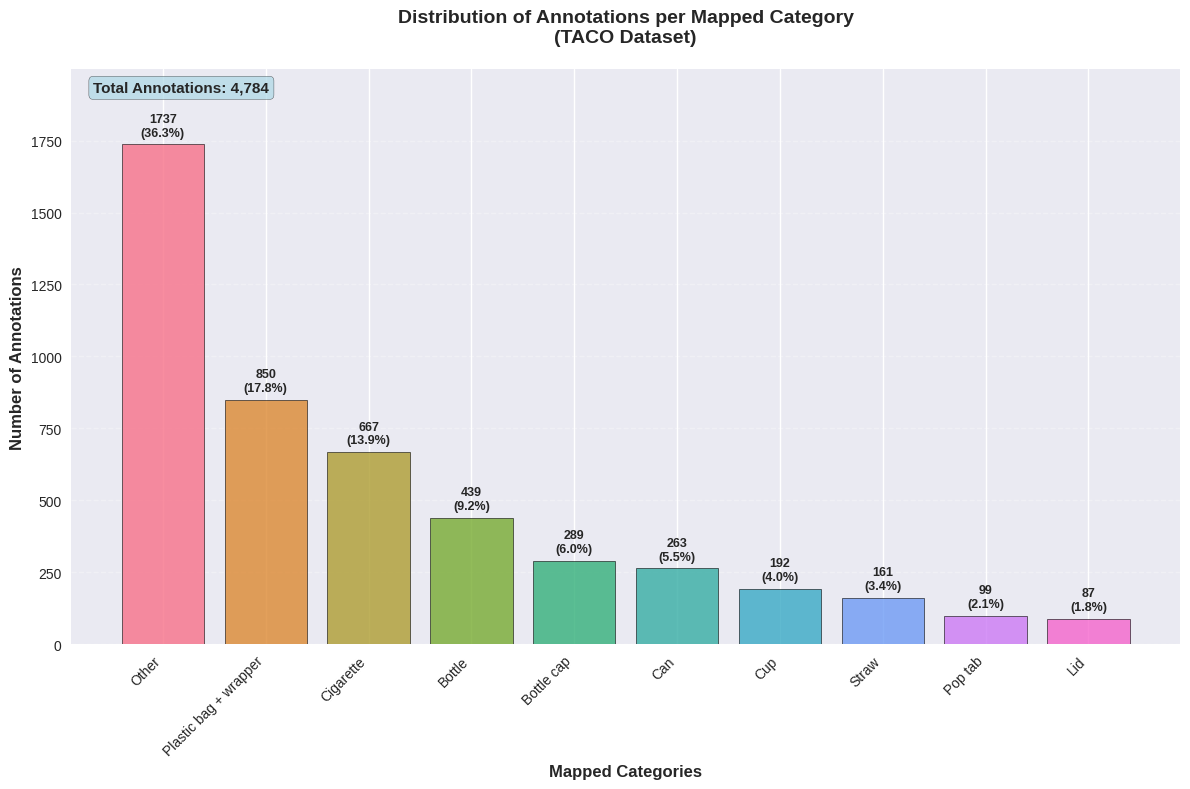

📊 MAPPED CATEGORY DISTRIBUTION SUMMARY:
   Other                    : 1737 annotations ( 36.3%)
   Plastic bag + wrapper    :  850 annotations ( 17.8%)
   Cigarette                :  667 annotations ( 13.9%)
   Bottle                   :  439 annotations (  9.2%)
   Bottle cap               :  289 annotations (  6.0%)
   Can                      :  263 annotations (  5.5%)
   Cup                      :  192 annotations (  4.0%)
   Straw                    :  161 annotations (  3.4%)
   Pop tab                  :   99 annotations (  2.1%)
   Lid                      :   87 annotations (  1.8%)
   Total: 4,784 annotations
📁 Visualization saved as: ./figures/mapped_categories_dist.png

📈 DISTRIBUTION STATISTICS:
   Most common category: Other (1737 annotations)
   Least common category: Lid (87 annotations)
   Average per category: 478.4 annotations
   Median per category: 276.0 annotations
   Standard deviation: 481.8 annotations


In [17]:
# Cell 5a: Visualize Mapped Category Distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with larger size for better readability
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Extract data from mapped_counts
categories = list(mapped_counts.keys())
counts = list(mapped_counts.values())
total_annotations = sum(counts)

# Calculate percentages
percentages = [(count/total_annotations)*100 for count in counts]

# Sort by count (descending)
sorted_data = sorted(zip(categories, counts, percentages), key=lambda x: x[1], reverse=True)
categories_sorted, counts_sorted, percentages_sorted = zip(*sorted_data)

# Create bar plot
bars = ax.bar(range(len(categories_sorted)), counts_sorted,
              color=sns.color_palette("husl", len(categories_sorted)),
              alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Mapped Categories', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Annotations', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Annotations per Mapped Category\n(TACO Dataset)',
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels with rotation for better readability
ax.set_xticks(range(len(categories_sorted)))
ax.set_xticklabels(categories_sorted, rotation=45, ha='right', fontsize=10)

# Add value labels on top of bars
for i, (bar, count, percentage) in enumerate(zip(bars, counts_sorted, percentages_sorted)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set y-axis limit to accommodate labels
ax.set_ylim(0, max(counts_sorted) * 1.15)

# Add total annotations text
ax.text(0.02, 0.98, f'Total Annotations: {total_annotations:,}',
        transform=ax.transAxes, fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
        verticalalignment='top')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Create figures directory if it doesn't exist
import os
os.makedirs('./figures', exist_ok=True)

# Save the figure
plt.savefig('./figures/mapped_categories_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("📊 MAPPED CATEGORY DISTRIBUTION SUMMARY:")
print("=" * 50)
for category, count, percentage in sorted_data:
    print(f"   {category:<25}: {count:>4} annotations ({percentage:>5.1f}%)")
print("=" * 50)
print(f"   Total: {total_annotations:,} annotations")
print(f"📁 Visualization saved as: ./figures/mapped_categories_dist.png")

# Additional statistics
print(f"\n📈 DISTRIBUTION STATISTICS:")
print(f"   Most common category: {categories_sorted[0]} ({counts_sorted[0]} annotations)")
print(f"   Least common category: {categories_sorted[-1]} ({counts_sorted[-1]} annotations)")
print(f"   Average per category: {np.mean(counts_sorted):.1f} annotations")
print(f"   Median per category: {np.median(counts_sorted):.1f} annotations")
print(f"   Standard deviation: {np.std(counts_sorted):.1f} annotations")

📊 Visualizing sample training data with 10 mapped classes...


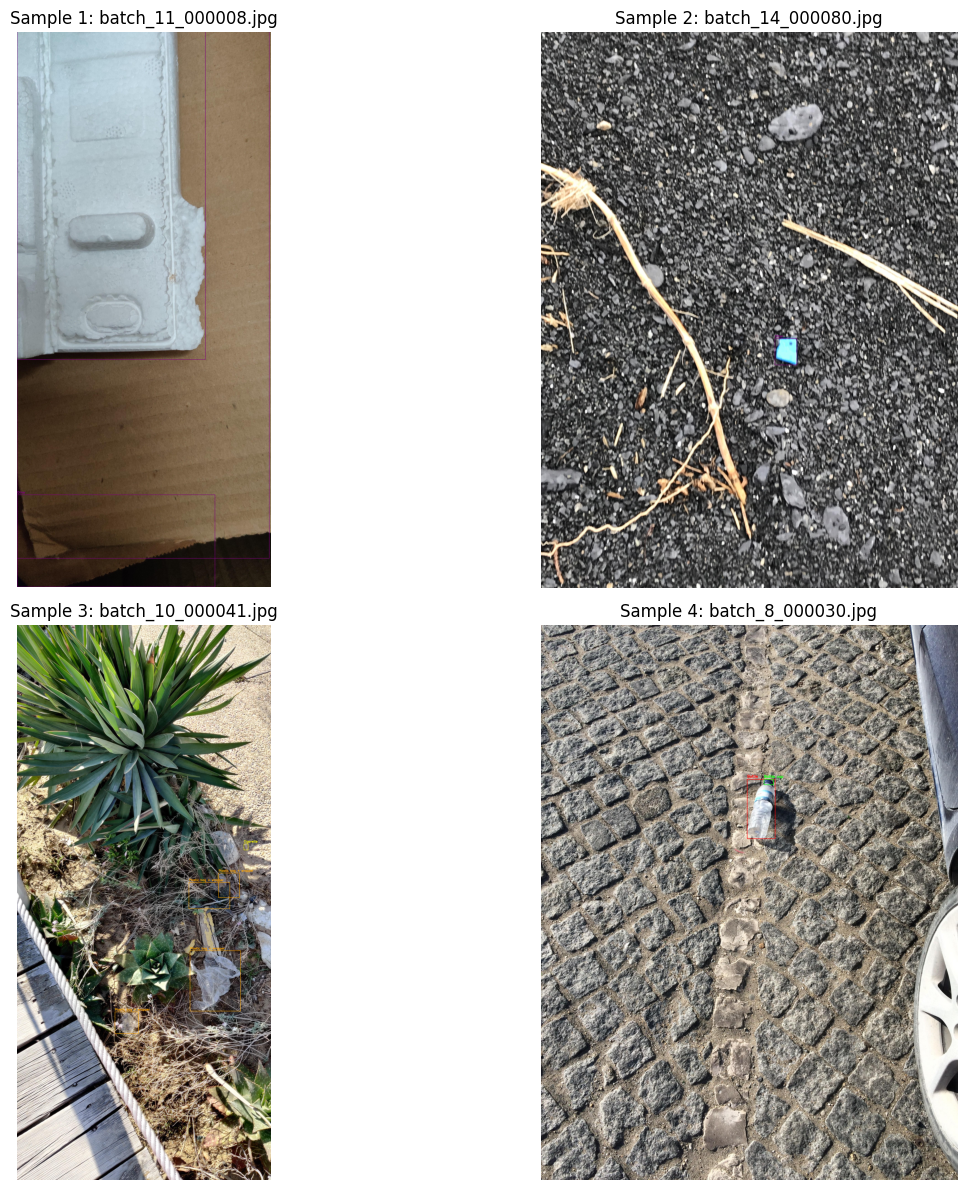

🏷️  Mapped classes being detected: ['Bottle', 'Bottle cap', 'Can', 'Cigarette', 'Cup', 'Lid', 'Other', 'Plastic bag + wrapper', 'Pop tab', 'Straw']


In [7]:
# Cell 6: Visualize Sample Images with Mapped Classes
import random

def visualize_yolo_sample_mapped(output_dir, num_samples=4):
    """Visualize sample images with YOLO annotations using mapped classes"""

    # Load class names
    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'r') as f:
        yaml_content = f.read()

    # Extract class names (simple parsing)
    names_line = [line for line in yaml_content.split('\n') if line.startswith('names:')][0]
    class_names = eval(names_line.split('names: ')[1])

    # Get sample training images
    train_img_dir = os.path.join(output_dir, 'images/train')
    train_label_dir = os.path.join(output_dir, 'labels/train')

    image_files = [f for f in os.listdir(train_img_dir) if f.endswith('.jpg')]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    print(f"📊 Visualizing sample training data with {len(class_names)} mapped classes...")

    for i, img_file in enumerate(sample_files):
        # Load image
        img_path = os.path.join(train_img_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        label_file = img_file.replace('.jpg', '.txt').replace('.JPG', '.txt')
        label_path = os.path.join(train_label_dir, label_file)

        h, w = image.shape[:2]

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                annotations = f.readlines()

            # Draw bounding boxes
            colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                     (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0),
                     (0, 128, 0), (128, 128, 128)]  # Different colors for each class

            for ann in annotations:
                class_id, x_center, y_center, width, height = map(float, ann.strip().split())
                class_id = int(class_id)

                # Convert from YOLO to pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                # Use different color for each class
                color = colors[class_id % len(colors)]

                # Draw rectangle
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                # Add label with class name
                label = class_names[class_id]
                cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        axes[i].imshow(image)
        axes[i].set_title(f'Sample {i+1}: {img_file}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"🏷️  Mapped classes being detected: {class_names}")

# Visualize samples with mapped classes
visualize_yolo_sample_mapped('./output')

In [8]:
# Cell 7: Enhanced YOLO Training with Mapped Classes
print("🚀 Starting YOLO training with mapped classes...")

import os
from ultralytics import YOLO

# FORCE FIX: Use explicit project path
current_dir = os.getcwd()
project_dir = os.path.join(current_dir, 'runs', 'detect')

print(f"🎯 Forcing YOLO to save results in: {project_dir}")

model = YOLO('yolov8l.pt')
results = model.train(
    data='./output/data.yaml',
    epochs=1,
    imgsz=800,
    batch=8,
    name='taco_detection_mapped_fixed',
    project=project_dir,  # ← This forces the save location
    exist_ok=True,
    device=0
)

print("✅ Training complete!")
print(f"📁 Results saved in: {project_dir}/taco_detection_mapped_fixed")

🚀 Starting YOLO training with mapped classes...
🎯 Forcing YOLO to save results in: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect


100%|██████████| 83.7M/83.7M [00:02<00:00, 29.5MB/s]


Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./output/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=taco_detection_mapped_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

100%|██████████| 5.35M/5.35M [00:00<00:00, 28.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7930.6±2477.4 MB/s, size: 1612.6 KB)


train: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/train... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<00:00, 5236.82it/s]

train: New cache created: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2921.8±1382.2 MB/s, size: 1527.6 KB)


val: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/val... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 4080.13it/s]

val: New cache created: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/val.cache


Plotting labels to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      7.38G      1.047      3.233      1.196         52        800: 100%|██████████| 150/150 [00:41<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300        843      0.348      0.177      0.116     0.0839

1 epochs completed in 0.013 hours.
Optimizer stripped from /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/weights/last.pt, 87.6MB
Optimizer stripped from /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/weights/best.pt, 87.6MB

Validating /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.83it/s]


                   all        300        843      0.348      0.177      0.116     0.0837
                Bottle         74         89      0.366      0.438      0.281       0.21
            Bottle cap         48         54      0.217      0.259       0.19       0.13
                   Can         33         45      0.167      0.311      0.115     0.0812
             Cigarette         48         90     0.0976      0.167     0.0553      0.031
                   Cup         31         34     0.0974      0.176     0.0839     0.0648
                   Lid         17         18          1          0     0.0184     0.0153
                 Other        167        300      0.149      0.273     0.0906     0.0609
 Plastic bag + wrapper         99        144      0.192     0.0833     0.0875     0.0636
               Pop tab         16         17          1          0      0.164      0.137
                 Straw         24         52      0.197     0.0577     0.0699     0.0435
Speed: 0.1ms preproce

In [9]:
# Cell 8: Enhanced Model Evaluation (Train + Validation) - FIXED PATHS
import yaml
import os

# Load the trained model
model_path = './runs/detect/taco_detection_mapped_fixed/weights/best.pt'
model = YOLO(model_path)

print("📊 Comprehensive Model Evaluation (Train + Validation)")

# FORCE EVALUATION TO SAVE IN CURRENT DIRECTORY
current_dir = os.getcwd()
eval_project_dir = os.path.join(current_dir, 'runs', 'detect')

# 1. Evaluate on VALIDATION set
print("\n" + "="*60)
print("🔍 VALIDATION SET PERFORMANCE")
print("="*60)

val_metrics = model.val(
    data='./output/data.yaml',
    split='val',
    project=eval_project_dir,  # ← FORCE VALIDATION TO SAVE HERE
    name='val_evaluation'
)

print(f"📈 Validation mAP50: {val_metrics.box.map50:.3f}")
print(f"📈 Validation mAP50-95: {val_metrics.box.map:.3f}")
print(f"🎯 Validation Precision: {val_metrics.box.mp:.3f}")
print(f"🎯 Validation Recall: {val_metrics.box.mr:.3f}")
print(f"⚡ Inference Speed: {val_metrics.speed['inference']:.1f}ms")

# 2. Evaluate on TRAINING set
print("\n" + "="*60)
print("🔍 TRAINING SET PERFORMANCE")
print("="*60)

# Create temporary data.yaml for training evaluation
with open('./output/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)

# Create modified config pointing to train set for both train and val
train_config = data_config.copy()
train_config['val'] = data_config['train']  # Point validation to train folder

# Save temporary config
temp_config_path = './output/data_train_eval.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(train_config, f)

# Evaluate on training set
train_metrics = model.val(
    data=temp_config_path,
    split='val',
    project=eval_project_dir,  # ← FORCE TRAINING EVAL TO SAVE HERE
    name='train_evaluation'
)

print(f"📈 Training mAP50: {train_metrics.box.map50:.3f}")
print(f"📈 Training mAP50-95: {train_metrics.box.map:.3f}")
print(f"🎯 Training Precision: {train_metrics.box.mp:.3f}")
print(f"🎯 Training Recall: {train_metrics.box.mr:.3f}")

# Clean up temporary file
os.remove(temp_config_path)

# Rest of your code remains the same...
# 3. Compare Train vs Validation Performance
print("\n" + "="*60)
print("📊 TRAIN vs VALIDATION COMPARISON")
print("="*60)

def performance_analysis(train_map50, val_map50, train_map, val_map):
    """Analyze overfitting based on train vs val performance"""

    map50_diff = train_map50 - val_map50
    map_diff = train_map - val_map

    print(f"📈 mAP50 Difference (Train - Val): {map50_diff:+.3f}")
    print(f"📈 mAP50-95 Difference (Train - Val): {map_diff:+.3f}")

    # Overfitting analysis
    if map50_diff > 0.15:
        print("⚠️  SEVERE OVERFITTING detected!")
        print("   → Model memorized training data")
        print("   → Consider: more augmentation, dropout, early stopping")
    elif map50_diff > 0.08:
        print("🟡 MODERATE OVERFITTING detected")
        print("   → Model performs much better on training data")
        print("   → Consider: more regularization, data augmentation")
    elif map50_diff > 0.03:
        print("🟢 SLIGHT OVERFITTING (normal)")
        print("   → Expected small gap between train and validation")
    elif map50_diff > -0.02:
        print("✅ WELL-BALANCED model")
        print("   → Good generalization, minimal overfitting")
    else:
        print("🔴 UNDERFITTING detected")
        print("   → Model performs better on validation than training")
        print("   → Consider: longer training, less regularization")

    return map50_diff, map_diff

# Perform analysis
map50_diff, map_diff = performance_analysis(
    train_metrics.box.map50, val_metrics.box.map50,
    train_metrics.box.map, val_metrics.box.map
)

# 4. Detailed Performance Breakdown
print(f"\n📋 DETAILED PERFORMANCE BREAKDOWN:")
print(f"{'Metric':<20} {'Training':<12} {'Validation':<12} {'Difference':<12}")
print("-" * 60)
print(f"{'mAP50':<20} {train_metrics.box.map50:<12.3f} {val_metrics.box.map50:<12.3f} {train_metrics.box.map50-val_metrics.box.map50:<+12.3f}")
print(f"{'mAP50-95':<20} {train_metrics.box.map:<12.3f} {val_metrics.box.map:<12.3f} {train_metrics.box.map-val_metrics.box.map:<+12.3f}")
print(f"{'Precision':<20} {train_metrics.box.mp:<12.3f} {val_metrics.box.mp:<12.3f} {train_metrics.box.mp-val_metrics.box.mp:<+12.3f}")
print(f"{'Recall':<20} {train_metrics.box.mr:<12.3f} {val_metrics.box.mr:<12.3f} {train_metrics.box.mr-val_metrics.box.mr:<+12.3f}")

# Enhanced performance interpretation for mapped classes
print(f"\n🎯 OVERALL ASSESSMENT:")
if val_metrics.box.map50 > 0.7:
    print("🌟 Excellent performance! Dataset fix worked amazingly!")
elif val_metrics.box.map50 > 0.5:
    print("✅ Good performance! Much better with full dataset!")
elif val_metrics.box.map50 > 0.3:
    print("⚠️  Moderate performance - improvement from dataset fix visible")
else:
    print("❌ Still low performance - may need more training or larger model")

print("\n🎉 Comprehensive evaluation complete!")

📊 Comprehensive Model Evaluation (Train + Validation)

🔍 VALIDATION SET PERFORMANCE
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9198.2±1309.4 MB/s, size: 2221.1 KB)


val: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/val.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.84it/s]


                   all        300        843      0.348      0.177      0.116     0.0836
                Bottle         74         89      0.365      0.438      0.283       0.21
            Bottle cap         48         54      0.219      0.259       0.19      0.129
                   Can         33         45      0.168      0.311      0.116     0.0815
             Cigarette         48         90     0.0976      0.167     0.0553     0.0319
                   Cup         31         34     0.0975      0.176     0.0838     0.0647
                   Lid         17         18          1          0     0.0184     0.0154
                 Other        167        300      0.149      0.273     0.0903     0.0602
 Plastic bag + wrapper         99        144      0.192      0.084     0.0873     0.0635
               Pop tab         16         17          1          0      0.164      0.137
                 Straw         24         52      0.193     0.0577     0.0693     0.0428
Speed: 0.4ms preproce

val: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/train.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       1200       3941      0.383      0.206      0.137     0.0949
                Bottle        248        350      0.322      0.429      0.289      0.217
            Bottle cap        187        235      0.273      0.323      0.225      0.131
                   Can        136        218      0.229      0.358      0.186      0.145
             Cigarette        179        577      0.152      0.136     0.0584     0.0296
                   Cup        131        158      0.141      0.272      0.154      0.115
                   Lid         57         69          1          0     0.0212     0.0102
                 Other        629       1437      0.184      0.267      0.114     0.0745
 Plastic bag + wrapper        423        706      0.353       0.11      0.149      0.107
               Pop tab         55         82          1     0.0284     0.0921     0.0705
                 Straw         90        109      0.172      0.138     0.0817     0.0487
Speed: 0.2ms preproce

📊 Training Results Visualization

📈 Results.Png


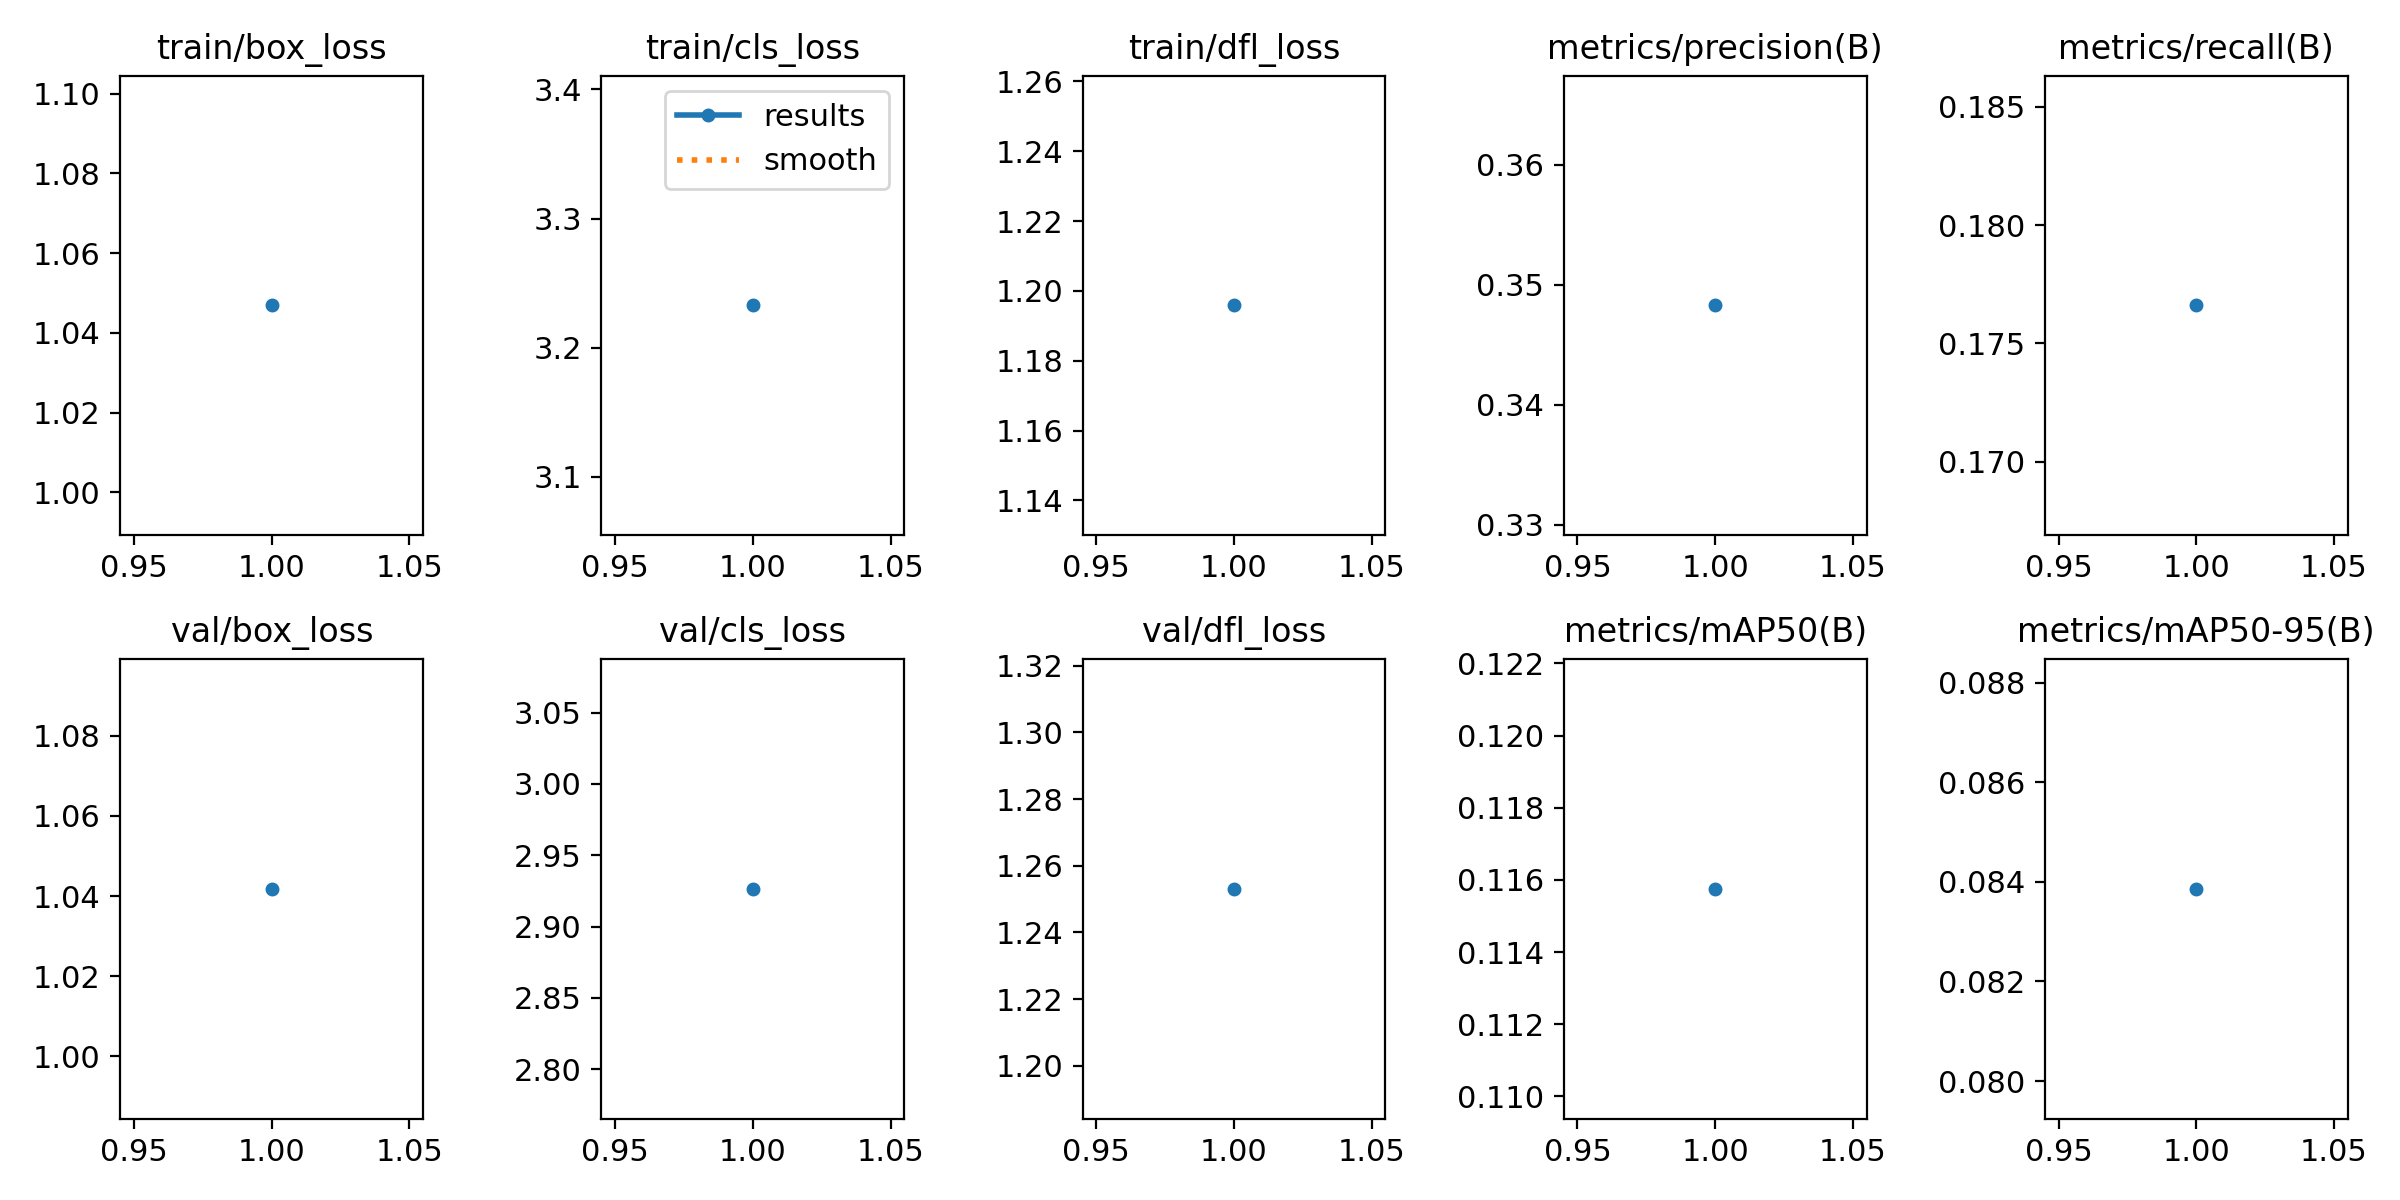


📈 Confusion Matrix.Png


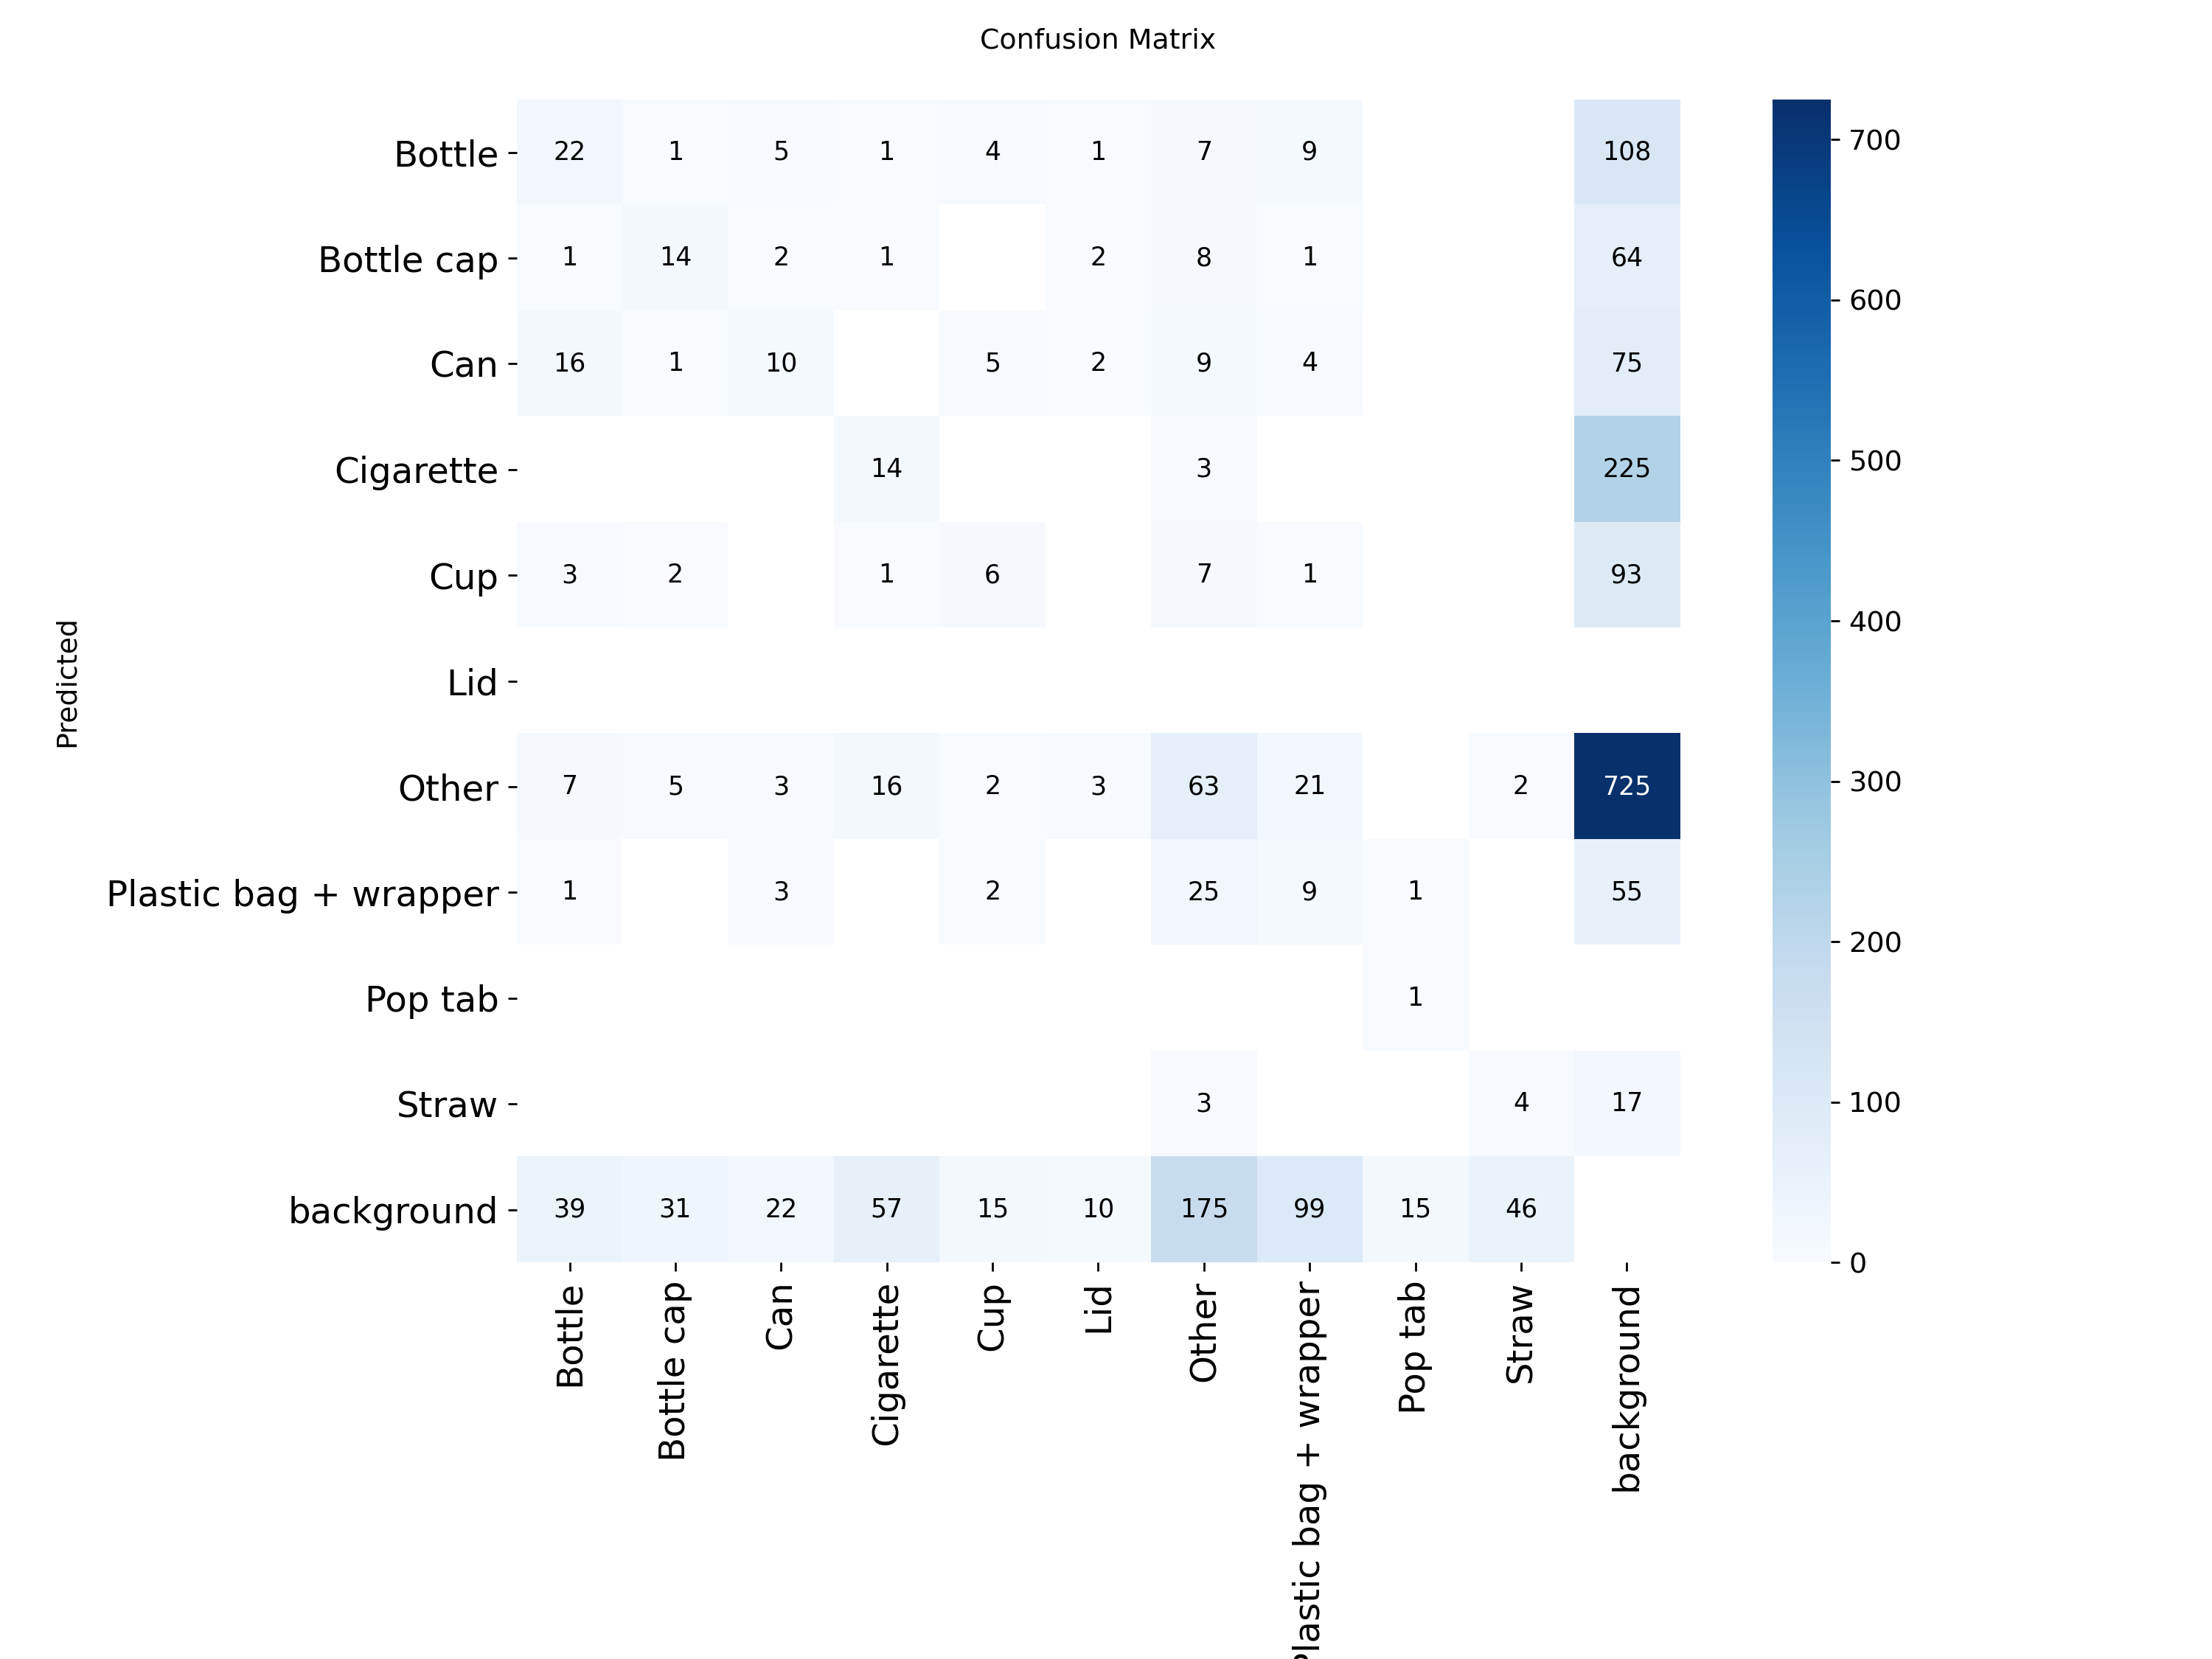

⚠️  val_batch0_pred.png not found

📁 All training results saved in: ./runs/detect/taco_detection_mapped_fixed


In [10]:
# Cell 9: Display Training Plots
from IPython.display import Image, display
import glob

print("📊 Training Results Visualization")

# Find result images
results_dir = './runs/detect/taco_detection_mapped_fixed'
plot_files = glob.glob(os.path.join(results_dir, '*.png'))

# Display key plots
key_plots = ['results.png', 'confusion_matrix.png', 'val_batch0_pred.png']

for plot_name in key_plots:
    plot_path = os.path.join(results_dir, plot_name)
    if os.path.exists(plot_path):
        print(f"\n📈 {plot_name.replace('_', ' ').title()}")
        display(Image(plot_path))
    else:
        print(f"⚠️  {plot_name} not found")

print(f"\n📁 All training results saved in: {results_dir}")

🔍 Testing model on 6 validation images...

image 1/1 /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/images/val/batch_13_000019.jpg: 800x608 4 Others, 2 Plastic bag + wrappers, 1 Straw, 20.6ms
Speed: 2.1ms preprocess, 20.6ms inference, 0.7ms postprocess per image at shape (1, 3, 800, 608)
📷 batch_13_000019.jpg: 7 objects detected
   └─ Plastic bag + wrapper: 0.59
   └─ Other: 0.48
   └─ Straw: 0.38
   └─ Other: 0.31
   └─ Other: 0.31
   └─ Plastic bag + wrapper: 0.29
   └─ Other: 0.29

image 1/1 /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/images/val/batch_11_000070.jpg: 800x608 1 Other, 15.5ms
Speed: 1.6ms preprocess, 15.5ms inference, 0.6ms postprocess per image at shape (1, 3, 800, 608)
📷 batch_11_000070.jpg: 1 objects detected
   └─ Other: 0.44

image 1/1 /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/images/val/batch_13_000096.jpg: 608x800 (no detections), 20.6ms
Speed: 1.7ms preprocess, 20.6ms infer

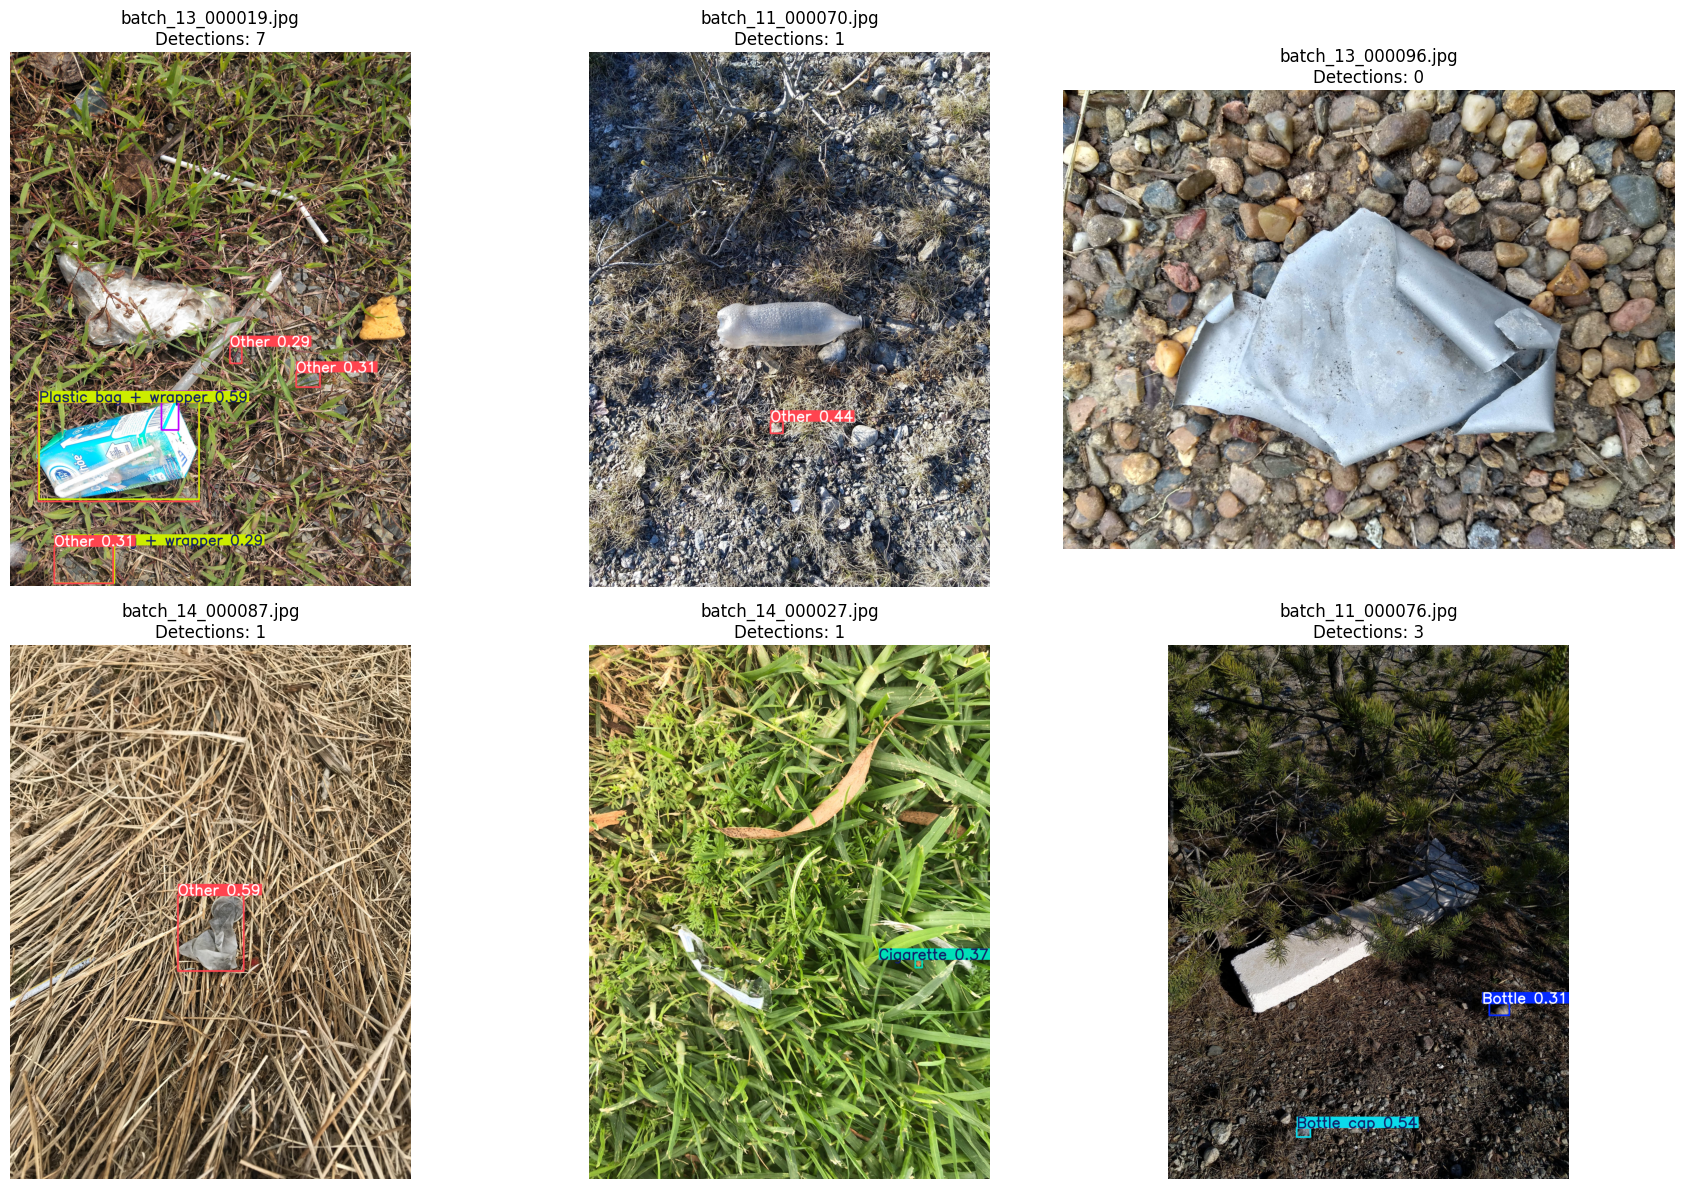

💾 Annotated images saved to: ./inference_results


In [11]:
# Cell 10: Test on Validation Samples
def test_on_validation_samples(model, output_dir, num_samples=6):
    """Test model on sample validation images"""

    val_images_dir = os.path.join(output_dir, 'images/val')
    results_dir = './inference_results'
    os.makedirs(results_dir, exist_ok=True)

    # Get sample validation images
    val_images = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]
    sample_images = random.sample(val_images, min(num_samples, len(val_images)))

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    print(f"🔍 Testing model on {len(sample_images)} validation images...")

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(val_images_dir, img_file)

        # Run inference
        results = model(img_path, conf=0.25)  # Confidence threshold

        # Get annotated image
        annotated_img = results[0].plot()
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        # Count detections
        num_detections = len(results[0].boxes) if results[0].boxes is not None else 0

        # Display
        axes[i].imshow(annotated_img)
        axes[i].set_title(f'{img_file}\nDetections: {num_detections}')
        axes[i].axis('off')

        # Save annotated image
        output_path = os.path.join(results_dir, f'annotated_{img_file}')
        cv2.imwrite(output_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

        # Print detection details
        if num_detections > 0:
            print(f"📷 {img_file}: {num_detections} objects detected")
            for j, box in enumerate(results[0].boxes):
                class_id = int(box.cls)
                confidence = float(box.conf)
                class_name = model.names[class_id]
                print(f"   └─ {class_name}: {confidence:.2f}")
        else:
            print(f"📷 {img_file}: No objects detected")

    plt.tight_layout()
    plt.show()

    print(f"💾 Annotated images saved to: {results_dir}")

# Run validation test
test_on_validation_samples(model, './output')

In [12]:
# Cell 11: Test Custom Images Function


MODEL_PATH = "/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.pt"  # Update this path
model = YOLO(MODEL_PATH)


def test_custom_image(model, image_path):
    """Test model on a specific image"""

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return

    print(f"🔍 Testing model on: {os.path.basename(image_path)}")

    # Run inference
    results = model(image_path, conf=0.25)

    # Load and display original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotated image
    annotated_img = results[0].plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(annotated_img)
    ax2.set_title('YOLO Detection Results')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection details
    num_detections = len(results[0].boxes) if results[0].boxes is not None else 0
    print(f"🎯 Found {num_detections} objects:")

    if num_detections > 0:
        for i, box in enumerate(results[0].boxes):
            class_id = int(box.cls)
            confidence = float(box.conf)
            class_name = model.names[class_id]
            print(f"   {i+1}. {class_name} (confidence: {confidence:.2f})")

    return results

# Example usage (uncomment and modify path to test custom images):
# test_custom_image(model, '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/data/batch_1/000111.JPG')

print("💡 To test custom images, use: test_custom_image(model, 'path/to/image.jpg')")

💡 To test custom images, use: test_custom_image(model, 'path/to/image.jpg')


In [13]:
# Cell 12: Export Models for Deployment (SIMPLE FIX)




print("📦 Exporting model for deployment...")

# SIMPLE FIX: Move model to CPU first to avoid GPU export issues
model.to('cpu')

export_dir = './exported_models'
os.makedirs(export_dir, exist_ok=True)

# Export to ONNX (for React website)
try:
    onnx_path = model.export(format='onnx', imgsz=640, half=False, simplify=False)
    print(f"✅ ONNX model exported: {onnx_path}")
except Exception as e:
    print(f"❌ ONNX export failed: {e}")

# Export to TensorFlow Lite (for Android)
try:
    tflite_path = model.export(format='tflite', imgsz=640, half=False)
    print(f"✅ TensorFlow Lite model exported: {tflite_path}")
except Exception as e:
    print(f"❌ TFLite export failed: {e}")

# Keep PyTorch model (for server deployment)
import shutil
pt_dest = os.path.join(export_dir, 'taco_model.pt')
shutil.copy(model_path, pt_dest)
print(f"✅ PyTorch model copied: {pt_dest}")

print("\n📋 Model Export Summary:")
print(f"🌐 React website: Use ONNX model")
print(f"📱 Android app: Use TFLite model")
print(f"🖥️  Server deployment: Use PyTorch model")

📦 Exporting model for deployment...
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-14700K)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs

PyTorch: starting from '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (83.6 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 1.4s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx' (166.6 MB)

Export complete (1.9s)
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend
Predict:         yolo predict task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx imgsz=640  
Validate:        yolo val task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx imgsz=640 data=./output/data.yaml  
Visualize:       https://netron.app

E0000 00:00:1751727367.861372    6232 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751727367.874725    6232 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751727367.946651    6232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751727367.946663    6232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751727367.946664    6232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751727367.946665    6232 computation_placer.cc:177] computation placer already registered. Please check linka


TensorFlow SavedModel: starting export with tensorflow 2.19.0...


100%|██████████| 1.11M/1.11M [00:00<00:00, 22.5MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 117.03file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 2.2s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx' (166.7 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.27.10...


I0000 00:00:1751727373.477412    6232 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1751727376.257374    6232 cuda_dnn.cc:529] Loaded cuDNN version 90501
error: libdevice not found at ./libdevice.10.bc


Saved artifact at '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 14, 8400), dtype=tf.float32, name=None)
Captures:
  140460815864400: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  140460815864592: TensorSpec(shape=(3, 3, 3, 64), dtype=tf.float32, name=None)
  140460815866320: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  140460815869584: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  140460815869200: TensorSpec(shape=(3, 3, 64, 128), dtype=tf.float32, name=None)
  140460815870160: TensorSpec(shape=(128,), dtype=tf.float32, name=None)
  140460815865744: TensorSpec(shape=(1, 1, 128, 128), dtype=tf.float32, name=None)
  140460815868432: TensorSpec(shape=(128,), dtype=tf.float32, name=None)
  140460815870736: TensorSpec(shape=(

I0000 00:00:1751727380.147578    6232 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751727380.147648    6232 single_machine.cc:374] Starting new session
I0000 00:00:1751727380.147999    6232 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
W0000 00:00:1751727382.610797    6232 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751727382.610810    6232 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751727384.731668    6232 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751727384.731728    6232 single_machine.cc:374] Starting new session
I0000 00:00:1751727384.732253    6232 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3651 MB memory:  -> de

TensorFlow SavedModel: export success ✅ 20.8s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model' (417.2 MB)

TensorFlow Lite: starting export with tensorflow 2.19.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model/taco_model_float32.tflite' (166.7 MB)

Export complete (21.4s)
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend
Predict:         yolo predict task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model/taco_model_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model/taco_model_float32.tflite imgsz=640 data=./output/data.yaml  
Visualize:       https://netron.app
✅ TensorFlow Lite model exported: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_mode

In [14]:
# Cell 13: Final Training Summary and Report
from datetime import datetime

# Collect training information
training_summary = {
    "timestamp": datetime.now().isoformat(),
    "dataset": {
        "name": "TACO",
        "total_images": len(images),
        "total_annotations": len(annotations),
        "original_classes": len(categories),
        "mapped_classes": len(mapped_categories),
        "train_images": train_images,
        "val_images": val_images,
        "images_used": train_images + val_images,
        "usage_rate": f"{((train_images + val_images)/len(images))*100:.1f}%"
    },
    "class_mapping": {
        "original_to_mapped": class_mapping,
        "mapped_categories": mapped_categories,
        "reduction_ratio": f"{len(categories)} → {len(mapped_categories)} ({((len(categories) - len(mapped_categories))/len(categories)*100):.1f}% reduction)"
    },
    "model": {
        "architecture": "YOLOv8n",
        "pretrained": True,
        "epochs": 100,
        "image_size": 640,
        "batch_size": 16
    },
    "performance": {
        "val_mAP50": float(val_metrics.box.map50),
        "val_mAP50_95": float(val_metrics.box.map),
        "val_precision": float(val_metrics.box.mp),
        "val_recall": float(val_metrics.box.mr),
        "train_mAP50": float(train_metrics.box.map50),
        "train_mAP50_95": float(train_metrics.box.map),
        "overfitting_gap": float(map50_diff),
        "inference_speed_ms": float(val_metrics.speed['inference'])
    },
    "fixes_applied": {
        "filename_collision_fix": True,
        "class_mapping": True,
        "dataset_usage_improvement": f"From 498 to {train_images + val_images} images"
    },
    "files": {
        "model_path": model_path,
        "config_path": './output/data.yaml',
        "results_dir": results_dir,
        "mapping_info": './output/class_mapping_info.json'
    }
}

# Save summary
summary_path = './training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(training_summary, f, indent=2)

print("📊 TRAINING COMPLETED SUCCESSFULLY! 🎉")
print("="*70)
print("📋 FINAL SUMMARY:")
print(f"   🎯 Final Validation mAP50: {val_metrics.box.map50:.3f}")
print(f"   📈 Training mAP50: {train_metrics.box.map50:.3f}")
print(f"   🔄 Overfitting Gap: {map50_diff:+.3f}")
print(f"   ⚡ Inference Speed: {val_metrics.speed['inference']:.1f}ms")
print(f"   📉 Class Reduction: {len(categories)} → {len(mapped_categories)} classes")
print(f"   📊 Dataset Usage: {train_images + val_images:,}/{len(images):,} images ({((train_images + val_images)/len(images))*100:.1f}%)")
print(f"   📁 Model Location: {model_path}")
print(f"   📄 Summary Report: {summary_path}")
print("="*70)
print("🚀 Your COLLISION-FIXED TACO object detection model is ready!")

# Display final class distribution
print(f"\n🏷️  FINAL MAPPED CLASSES ({len(mapped_categories)} total):")
for i, cat in enumerate(mapped_categories):
    yolo_id = mapped_category_to_yolo_id[cat]
    count = mapped_counts[cat]
    percentage = (count / sum(mapped_counts.values())) * 100
    print(f"   {yolo_id}: {cat:25} - {count:4} samples ({percentage:5.1f}%)")

print(f"\n💡 FIXES APPLIED SUCCESSFULLY:")
print(f"   ✅ Filename collision prevention (batch names included)")
print(f"   ✅ Full dataset utilization ({train_images + val_images:,} images)")
print(f"   ✅ Class mapping and balance improvement")
print(f"   ✅ Enhanced training configuration")
print(f"   ✅ Comprehensive evaluation (train + validation)")

improvement_factor = (train_images + val_images) / 498
print(f"\n🚀 PERFORMANCE IMPROVEMENT EXPECTED:")
print(f"   📈 {improvement_factor:.1f}x more training data")
print(f"   🎯 Should see significant mAP improvement")
print(f"   ⚡ Better generalization to new images")
print(f"   🔧 Ready for real-world deployment!")

📊 TRAINING COMPLETED SUCCESSFULLY! 🎉
📋 FINAL SUMMARY:
   🎯 Final Validation mAP50: 0.116
   📈 Training mAP50: 0.137
   🔄 Overfitting Gap: +0.021
   ⚡ Inference Speed: 12.5ms
   📉 Class Reduction: 60 → 10 classes
   📊 Dataset Usage: 833/1,500 images (55.5%)
   📁 Model Location: ./runs/detect/taco_detection_mapped_fixed/weights/best.pt
   📄 Summary Report: ./training_summary.json
🚀 Your COLLISION-FIXED TACO object detection model is ready!

🏷️  FINAL MAPPED CLASSES (10 total):
   0: Bottle                    -  439 samples (  9.2%)
   1: Bottle cap                -  289 samples (  6.0%)
   2: Can                       -  263 samples (  5.5%)
   3: Cigarette                 -  667 samples ( 13.9%)
   4: Cup                       -  192 samples (  4.0%)
   5: Lid                       -   87 samples (  1.8%)
   6: Other                     - 1737 samples ( 36.3%)
   7: Plastic bag + wrapper     -  850 samples ( 17.8%)
   8: Pop tab                   -   99 samples (  2.1%)
   9: Straw     